In [7]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from datetime import datetime
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'

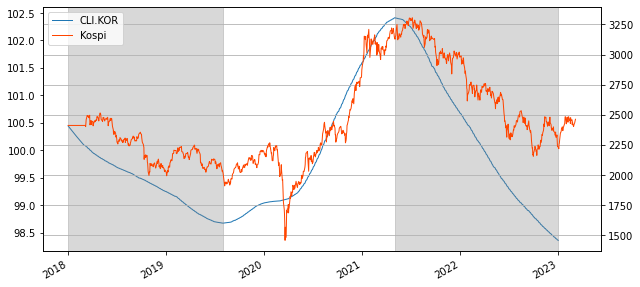

,Kospi
Date,
2018-03-06,2411.409912
2018-03-07,2401.820068
2018-03-08,2433.080078
2018-03-09,2459.449951
2018-03-12,2484.120117
...,...
2023-02-27,2402.639893
2023-02-28,2412.850098
2023-03-02,2427.850098


In [13]:

# Composite Leading Indicator
# https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
def getCLI(country):
    uri = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/' + country + '.CLI.AMPLITUD.LTRENDIDX.M/OECD?json-lang=en&dimensionAtObservation=allDimensions&startPeriod=2018-01&endPeriod=2023-12'
    resp = requests.get(uri)
    result = json.loads(resp.text)

    dates = []
    cli = []
    cli_code = 'CLI.' + country

    observations = result['dataSets'][0]['observations']
    for key in observations:
        obs = observations[key][0]
        cli.append(obs)

    time_period = result['structure']['dimensions']['observation'][5]['values']
    for date in time_period:
        date = date['id']
        year = int(date[:4])
        month = int(date[5:7])
        dates.append(datetime(year=year, month=month, day=1))

    df = pd.DataFrame(data=cli, index=dates, columns=[cli_code])
    return df

def GetYahooFinance(name, code):
    ticker = yf.Ticker(code)
    ticker = ticker.history(period='5y')
    ticker = ticker[['Close']]
    ticker.rename(columns={'Close': name}, inplace=True)
    return ticker

code_names = [('KOR', 'Kospi', '^KS11')]

for country_code, yf_name, yf_code in code_names:
    cli_code = 'CLI.' + country_code
    cli = getCLI(country_code)
    cli = cli.tz_localize(None)

    ticker = GetYahooFinance(yf_name, yf_code)
    ticker = ticker.tz_localize(None)    

    df = pd.concat([cli[cli_code], ticker[yf_name]], axis=1)
    df = df.interpolate(limit_direction='backward')

fig = plt.figure()
ax = fig.add_subplot(111)
df[cli_code].plot(ax=ax)
ax2 = ax.twinx()
df[yf_name].plot(ax=ax2, color='orangered')
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes)

gradient = np.gradient(df[cli_code])
warnings = pd.Series(gradient < 0, index=df.index)

range_list = []
prev_val = False
for index, value in warnings.iteritems():
    if prev_val != value:
        if value:
            begin = index
        else:
            range_list.append((begin, index))

    prev_inx = index
    prev_val = value

for (begin, end) in range_list:
    plt.axvspan(begin, end, color='gray', alpha=0.3)

plt.grid()
plt.show()    
ticker